# Compute the Budyko precipitation recycling ratio

In [1]:
import os
import glob
import math
import numpy as np
import xarray as xr
import pickle

# Regridding
# import xesmf as xe

def find_dl(lat, lons):
    """
    Find average length of 1 grid cell - convert lat to radians, take cos +
    divide by Earth's circumference (m)
    """
    earth_circ = (40075*10**3)  # Earth's circumference in m
    lon_shape = len([lons])
    lat_rad = np.radians(abs(lat))
    dl = math.cos(lat_rad) * (earth_circ / lon_shape)  # length of pixel in m
    return dl

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

def get_pixel_size(lat, lon):
    if lat[0] > lat[-1]:
        temp_lat = lat[::-1]
    else:
        temp_lat = lat
    r = 6.371 * 1e6
    rad = (2 * math.pi / 360)  # (m)
    da = np.nan * np.zeros((len(temp_lat)))  # (m^2)

    for i in range(len(temp_lat) - 1):
        da[i] = (2 * math.pi * (1 / len(lon)) *
                 r ** 2 * (math.sin(rad * temp_lat[i + 1]) -
                           math.sin(rad * temp_lat[i])))

    # Check if top and bottom latitude are same
    if temp_lat[0] == -temp_lat[-1]:
        da[-1] = da[0]
    return da

In [70]:
models = [ "ACCESS-ESM1-5", "CanESM5", "IPSL-CM6A-LR", "MPI-ESM1-2-LR", "UKESM1-0-LL", ]

In [72]:

# mm = models[0]
for m, mm in enumerate(models):
    # Open data
    data_path = "F:/Data/LUMIP"
    q1 = xr.open_dataset(glob.glob(os.path.join(data_path + "/" + mm + "/" + "hus_Amon_" + mm + "_ssp370_" + "*.nc"))[0], engine = 'netcdf4', chunks={"time": 258})["hus"]  # Specific humidity (kg/kg)
    u1 = xr.open_dataset(glob.glob(os.path.join(data_path + "/" + mm + "/" + "ua_Amon_" + mm + "_ssp370_" + "*.nc"))[0], engine = 'netcdf4', chunks={"time": 258})["ua"]  # Zonal wind (m/s)
    v1 = xr.open_dataset(glob.glob(os.path.join(data_path + "/" + mm + "/" + "va_Amon_" + mm + "_ssp370_" + "*.nc"))[0], engine = 'netcdf4', chunks={"time": 258})["va"]  # Meridional wind (m/s)  

    q2 = xr.open_dataset(glob.glob(os.path.join(data_path + "/" + mm + "/" + "hus_Amon_" + mm + "_ssp370-ssp126Lu_" + "*.nc"))[0], engine = 'netcdf4', chunks={"time": 258})["hus"]  # Specific humidity (kg/kg)
    u2 = xr.open_dataset(glob.glob(os.path.join(data_path + "/" + mm + "/" + "ua_Amon_" + mm + "_ssp370-ssp126Lu_" + "*.nc"))[0], engine = 'netcdf4', chunks={"time": 258})["ua"]  # Zonal wind (m/s)
    v2 = xr.open_dataset(glob.glob(os.path.join(data_path + "/" + mm + "/" + "va_Amon_" + mm + "_ssp370-ssp126Lu_" + "*.nc"))[0], engine = 'netcdf4', chunks={"time": 258})["va"]  # Meridional wind (m/s)

    data_path = "G:/My Drive/MPIM/data/"
    scenario = 'ssp126Lu'
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]   ## List of files sorted by name
    xr_aff_pft = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 258})["treeFrac"]
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]   ## List of files sorted by name
    xr_aff = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 258})["evspsbl"]
    scenario = 'ssp370'
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]   ## List of files sorted by name
    xr_ctl_pft = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 258})["treeFrac"]
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]   ## List of files sorted by name
    xr_ctl = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 258})["evspsbl"]

    # Preprocess data
    xr_delta_pft = xr_aff_pft.sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl_pft.sel(time = slice("2071-01","2100-12")).mean(dim = "time")
    treefrac_pos = xr_delta_pft.where(xr_delta_pft > 10)

    et = xr_aff - xr_ctl  # Evapotranspiration in Kg m-2 s-1
    q2.assign_coords(time = q2.time); q2 = q2.assign_coords(plev=q1.plev)
    u2.assign_coords(time = u2.time); u2 = u2.assign_coords(plev=u1.plev)
    v2.assign_coords(time = v2.time); v2 = v2.assign_coords(plev=v1.plev)

    q = (q2 - q1)*1e-3      # Specific humidity in Kg ????
    u = (u2 - u1)           # Eastward winds in m s-1
    v = (v2 - v1)           # Northward winds in m s-1

    q = q.sel(lat=slice(-61,90))
    u = u.sel(lat=slice(-61,90))
    v = v.sel(lat=slice(-61,90))
    if treefrac_pos.lat.shape != q.lat.shape:   
        q = q.sel(lat=slice(-60,90))
        u = u.sel(lat=slice(-60,90))
        v = v.sel(lat=slice(-60,90))
    if u.lat.shape != q.lat.shape:   
        u = u.sel(lat=slice(-60,89))
        v = v.sel(lat=slice(-60,89))

    q = lon180(q); u = lon180(u); v = lon180(v); et = lon180(et)
    q = q.assign_coords(lat = u.lat); q = q.assign_coords(lon = u.lon);
    treefrac_pos = treefrac_pos.assign_coords(lat = q.lat); treefrac_pos = treefrac_pos.assign_coords(lon = q.lon)
    et = et.assign_coords(lat = q.lat); et = et.assign_coords(lon = q.lon); et = et.assign_coords(time = q.time)

    # Ensure that the datasets have matching dimensions
    assert q.dims == u.dims == v.dims

    # Pressure levels (Pa)
    pressure = (q.coords['plev'])

    # Calculate the zonal (qx) and meridional (qy) water vapor fluxes (kg/(m^2*s))
    qx = q * u
    qy = q * v

    # Integrate vertically over all pressure levels
    # Use the trapezoidal rule for integration
    dp = np.diff(pressure)  # Difference between consecutive pressure levels

    # Add an extra level at the top for integration purposes
    dp = np.append(dp, dp[-1])

    # Reshape dp to make it broadcastable across qx and qy
    dp = dp.reshape((1, -1, 1, 1))

    # Vertical integration
    # Multiply each level flux by the corresponding pressure difference and integrate
    qu = (qx * dp).sum(dim='plev') / 9.81  # Dividing by gravitational acceleration to convert to (kg/m^2/s)
    qv = (qy * dp).sum(dim='plev') / 9.81

    # Resulting vertically integrated water vapor fluxes
    print(qu)
    print(qv)

    pixel_size_grid = get_pixel_size(qu.lat.values, qu.lon.values)
    pixel_size_grid = np.array([pixel_size_grid]*len(qu.lon)).transpose()

    qu = qu.compute()
    qv = qv.compute()
    et = et.compute()

    # Compute the operation on the cells with at least 10% of increased treeFrac in the 2070-2100 period
    cells = treefrac_pos.stack(cell = ["lon","lat"]).where(treefrac_pos.stack(cell = ["lon","lat"]).notnull(), drop = True).cell 
    grids = cells.values
    res_y = (treefrac_pos.lat[1] - treefrac_pos.lat[0]).values
    res_x = (treefrac_pos.lon[1] - treefrac_pos.lon[0]).values

    qu_stack = qu.stack(cell = ["lon","lat"])
    qv_stack = qv.stack(cell = ["lon","lat"])
    et_stack = et.stack(cell = ["lon","lat"])

    xr_B = xr.DataArray(data=None, coords=[qu_stack.time,qu_stack.cell], dims=["time","cell"])
    xr_B["B"] = xr.DataArray(data=None, coords=[qu_stack.time,qu_stack.cell], dims=["time","cell"])
    xr_B["Rr"] = xr.DataArray(data=None, coords=[qu_stack.time,qu_stack.cell], dims=["time","cell"])
    xr_B["Fin"] = xr.DataArray(data=None, coords=[qu_stack.time,qu_stack.cell], dims=["time","cell"])
    xr_B["EA"] = xr.DataArray(data=None, coords=[qu_stack.time,qu_stack.cell], dims=["time","cell"])

    # Iterate Precipitation recycling ration over cells of Delta_treefrac>10%
    for i,c in enumerate(cells):
        locator = {'cell':c}
        g = grids[i]

        # Lon & Lat indices 
        ilon = np.where(qu.lon == g[0])[0][0]
        ilat = np.where(qu.lat == g[1])[0][0]

        lonmin = g[0] - res_x/2
        lonmax = g[0] + res_x/2
        latmin = g[1] - res_y/2
        latmax = g[1] + res_y/2

        # Find average grid cell length on E, W, N and S sides of domain in m

        dl_e = find_dl(np.mean((latmin, latmax)), lonmax)
        dl_w = find_dl(np.mean((latmin, latmax)), lonmin)
        dl_n = find_dl(latmax, np.mean((lonmin, lonmax)))
        dl_s = find_dl(latmin, np.mean((lonmin, lonmax)))

        # Calculate inward moisture flux in kg s-1
        # Get water vapour flux for each pixel along transect (kg m-1 s-1) and
        # multiply by pixel lenth (m) to get units of kg s-1
        # i.e. for each pixel change units to kg s-1

        inflow_from_E = -dl_e*qu_stack.loc[locator]
        inflow_from_W = dl_w*qu_stack.loc[locator]
        inflow_from_N = -dl_n*qv_stack.loc[locator]
        inflow_from_S = dl_s*qv_stack.loc[locator]

        # Initialize flux_in and flux_out with zeros
        flux_in = xr.zeros_like(inflow_from_E)
        flux_out = xr.zeros_like(inflow_from_E)

        # Calculate total water vapour flux into the cell
        # Calculate flux_in and flux_out using vectorized operations
        flux_in += inflow_from_E.where(inflow_from_E > 0, 0)
        #flux_out += abs(inflow_from_E.where(inflow_from_E < 0, 0))

        flux_in += inflow_from_W.where(inflow_from_W > 0, 0)
        #flux_out += abs(inflow_from_W.where(inflow_from_W < 0, 0))

        flux_in += inflow_from_N.where(inflow_from_N > 0, 0)
        #flux_out += abs(inflow_from_N.where(inflow_from_N < 0, 0))

        flux_in += inflow_from_S.where(inflow_from_S > 0, 0)
        #flux_out += abs(inflow_from_S.where(inflow_from_S < 0, 0))

        # Calculate Budyko recycling coefficient
        A = pixel_size_grid[ilat,ilon]
        EA = et_stack.loc[locator] * A

        B = 1 + (EA.values/(2*flux_in.values))
        Rr = 1 - (1/B)

        xr_B["B"].loc[locator] =  xr.DataArray(data = B)
        xr_B["Rr"].loc[locator] =  xr.DataArray(data = Rr)
        xr_B["Fin"].loc[locator] =  xr.DataArray(data = flux_in)
        xr_B["EA"].loc[locator] =  xr.DataArray(data = EA)


    xr_B = xr_B.unstack()
    xr_B["B"] = xr_B["B"].astype(np.float64)
    xr_B["Rr"] = xr_B["Rr"].astype(np.float64)
    xr_B["Fin"] = xr_B["Fin"].astype(np.float64)    # kg s-1
    xr_B["EA"] = xr_B["EA"].astype(np.float64)    # kg s-1

    # Save and export regression list data
    import pickle
    out_path = "G:/My Drive/MPIM/data/"

    with open(os.path.join(out_path+"budyko_pr_"+mm), "wb") as fp:   #Pickling
        pickle.dump(xr_B, fp)

    # Free up memory
    del(q,u,v,q1,q2,u1,u2,v1,v2,et)


c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\m

<xarray.DataArray (time: 1032, lat: 121, lon: 192)>
dask.array<truediv, shape=(1032, 121, 192), dtype=float64, chunksize=(258, 121, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat      (lat) float64 -60.62 -59.38 -58.12 -56.88 ... 86.88 88.12 89.38
  * lon      (lon) float64 -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
<xarray.DataArray (time: 1032, lat: 121, lon: 192)>
dask.array<truediv, shape=(1032, 121, 192), dtype=float64, chunksize=(258, 121, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat      (lat) float64 -60.62 -59.38 -58.12 -56.88 ... 86.88 88.12 89.38
  * lon      (lon) float64 -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
<xarray.DataArray (time: 1032, lat: 54, lon: 128)>
dask.array<truediv, shape=(1032, 54, 128), dtype=float64, chunksize=(258, 54, 128), chunktype=numpy.ndarray>
Coordinates:
  * time 

C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local

<xarray.DataArray (time: 1032, lat: 119, lon: 144)>
dask.array<truediv, shape=(1032, 119, 144), dtype=float32, chunksize=(258, 119, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -59.58 -58.31 -57.04 -55.77 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
<xarray.DataArray (time: 1032, lat: 119, lon: 144)>
dask.array<truediv, shape=(1032, 119, 144), dtype=float32, chunksize=(258, 119, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -59.58 -58.31 -57.04 -55.77 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00


c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\m

<xarray.DataArray (time: 1032, lat: 80, lon: 192)>
dask.array<truediv, shape=(1032, 80, 192), dtype=float64, chunksize=(258, 80, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 -58.76 -56.89 -55.02 -53.16 ... 84.86 86.72 88.57
<xarray.DataArray (time: 1032, lat: 80, lon: 192)>
dask.array<truediv, shape=(1032, 80, 192), dtype=float64, chunksize=(258, 80, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 -58.76 -56.89 -55.02 -53.16 ... 84.86 86.72 88.57


c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
c:\Users\m

<xarray.DataArray (time: 1032, lat: 120, lon: 192)>
dask.array<truediv, shape=(1032, 120, 192), dtype=float64, chunksize=(258, 120, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 -60.0 -58.75 -57.5 -56.25 ... 85.0 86.25 87.5 88.75
<xarray.DataArray (time: 1032, lat: 120, lon: 192)>
dask.array<truediv, shape=(1032, 120, 192), dtype=float64, chunksize=(258, 120, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 -60.0 -58.75 -57.5 -56.25 ... 85.0 86.25 87.5 88.75


C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local\Temp\ipykernel_31876\4079594454.py:159: RuntimeWarning: invalid value encountered in divide
  B = 1 + (EA.values/(2*flux_in.values))
C:\Users\mastr\AppData\Local

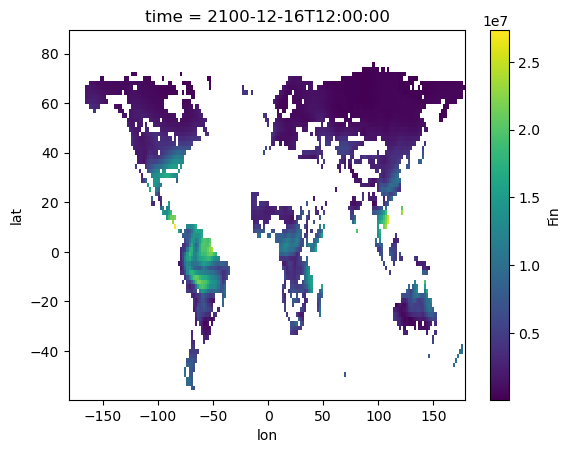

In [65]:
(xr_B.isel(time = -1).Fin).plot(x = "lon")

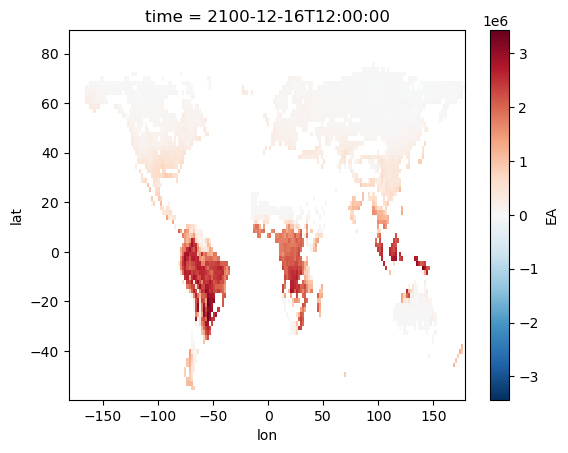

In [66]:
(xr_B.isel(time = -1).EA).plot(x = "lon")

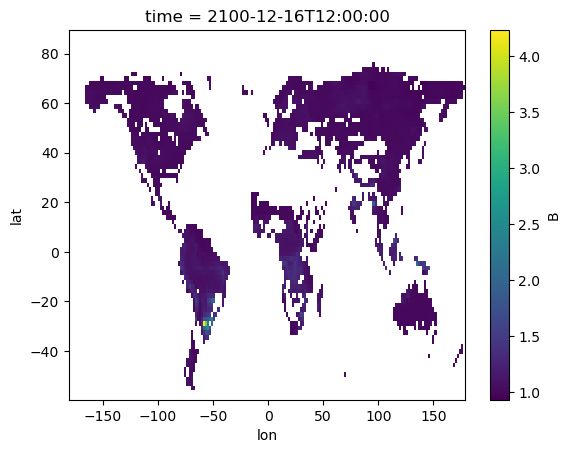

In [68]:
(xr_B.isel(time = -1).B).plot(x = "lon")

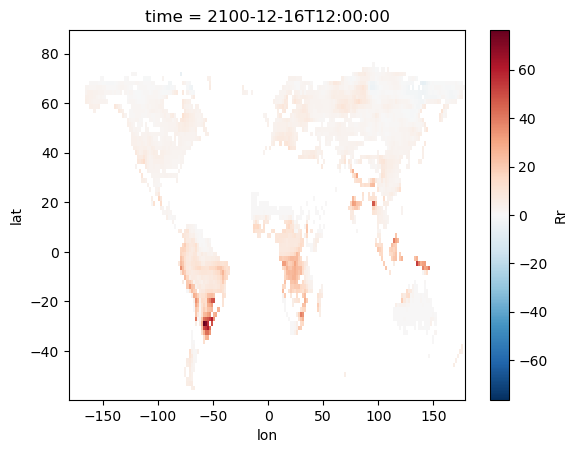

In [67]:
(xr_B.isel(time = -1).Rr*100).plot(x = "lon")